<a href="https://colab.research.google.com/github/bablooashok/Face-Mask-Detection/blob/master/Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2,os

data_path='/content/drive/My Drive/data'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels))

print(label_dict)
print(categories)
print(labels)

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]


In [3]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 100x100, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

In [4]:
import numpy as np
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)

In [5]:
np.save('data',data)
np.save('target',new_target)

In [6]:
data=np.load('data.npy')
target=np.load('target.npy')

In [7]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(100,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50,activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [8]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [9]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=20,callbacks=[checkpoint],validation_split=0.2)

Epoch 1/20
32/32 [==============================] - ETA: 0s - loss: 0.7758 - accuracy: 0.5277WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model-001.model/assets
32/32 [==============================] - 48s 1s/step - loss: 0.7758 - accuracy: 0.5277 - val_loss: 0.6930 - val_accuracy: 0.5138
Epoch 2/20
32/32 [==============================] - 44s 1s/step - loss: 0.6771 - accuracy: 0.5543 - val_loss: 0.6311 - val_accuracy: 0.6403
Epoch 3/20
32/32 [==============================] - 44s 1s/step - loss: 0.5666 - accuracy: 0.6937 - val_loss

In [10]:
print(model.evaluate(test_data,test_target))

5/5 [==============================] - 1s 236ms/step - loss: 0.0983 - accuracy: 0.9787
[0.09828858822584152, 0.978723406791687]


In [11]:
from keras.models import load_model
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [14]:
!pwd
%cd '/content/'

/content/drive/My Drive
/content


In [15]:
model = load_model('model-017.model')

face_clsfr=cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

labels_dict={0:'without_mask',1:'with_mask'}
color_dict={0:(0,0,255),1:(0,255,0)}

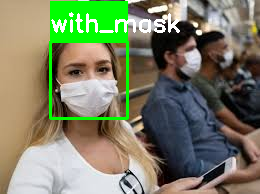

In [21]:
img=cv2.imread('/content/drive/My Drive/02.jpg')    
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

faces = face_clsfr.detectMultiScale(gray,1.3,5)
if len(faces)>0:
  [x,y,w,h]=faces[0]
  face_img=gray[y:y+w,x:x+w]
  resized=cv2.resize(face_img,(100,100))
  normalized=resized/255.0
  reshaped=np.reshape(normalized,(1,100,100,1))
  result=model.predict(reshaped)

  label=np.argmax(result,axis=1)[0]
        
  cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
  cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
  cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
          
          
  cv2_imshow(img)
else:
  print("Face not found")